# RNA velocity: Current challenges and future perspectives

This notebooks is complementary to **Bergen et al. (2021)**, ***RNA velocity: Current challenges and future perspectives***. 


The following examples are provided to discuss potential pitfalls:

- multiple kinetics in Dentate Gyrus
- transcriptional boost in erythroid lineage
- mature cell types in PBMCs

In the manuscript, for each example, we provide guidance on how the ensuing challenges may be addressed.
***

In [1]:
import numpy as np
import pandas as pd
import scvelo as scv

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
scv.set_figure_params(dpi=100, fontsize=16, facecolor='none')  # set dpi=200 to generate high-res figures
scv.settings.verbosity = 1  # set to 3 to see more information
scv.logging.print_version()

Running scvelo 0.2.4.dev56+g12a5e9c (python 3.8.0) on 2021-08-25 08:29.


***

## Multiple kinetic regimes in Dentate Gyrus
As described in the seminal works (La Manno et al, 2018; Bergen et al, 2020), some genes show multiple kinetic regimes across subpopulations and lineages (Fig. 2a). These can be governed by variations in kinetic rates, and manifest as multiple trajectories in phase space. Additionally, we frequently find subpopulations to show a straight line in phase portraits since the expression kinetics is only partially observed. This lack of curvature challenges current models when determining whether an up- or down-regulation should be fit. In fact, the lack of curvature reveals another fundamental assumption for extracting dynamic information from spliced and unspliced abundances: The expression kinetics must be sufficiently observed and occur on a comparable time scale as the differentiation process. A timescale mismatch would lead to phase portraits showing a noisy blob or a straight line rather than an interpretable curvature. 

**Proposed Solution**: State-dependent rates, multi-modal omics (see mannuscript). 


#### Dentate Gyrus I
Reproducing Suppl. Fig. 7 from La Manno et al. ([Nature, 2018](https://doi.org/10.1038/s41586-018-0414-6)).

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


saving figure to file ./figures/scvelo_DG_large.png


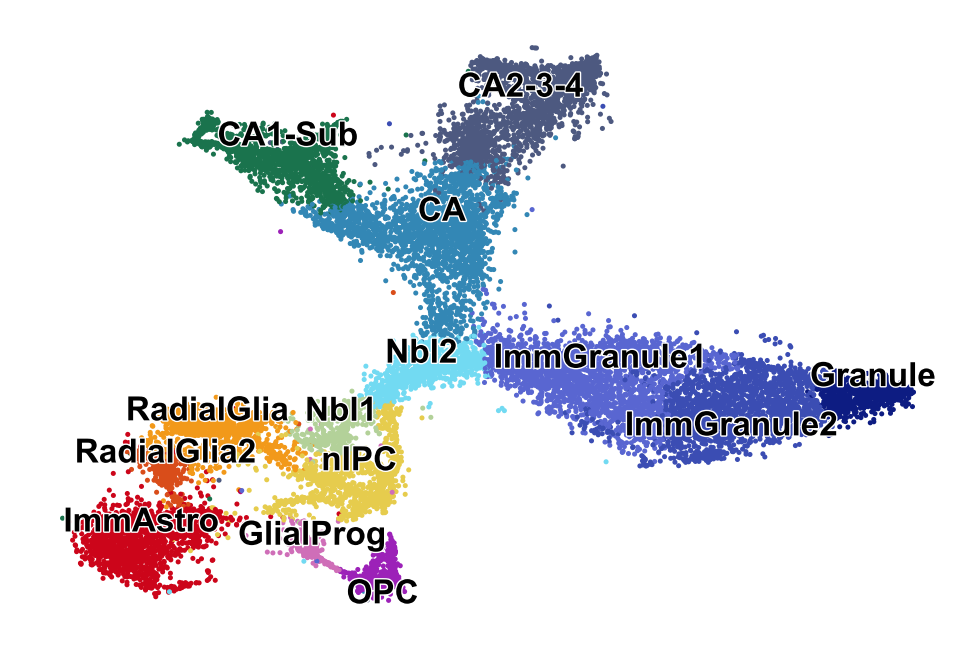

In [4]:
adata = scv.datasets.dentategyrus_lamanno()
scv.pl.scatter(adata, legend_fontsize=12, legend_align_text=True, title='', save='DG_large.png')

In [5]:
var_names = ['Ntrk2', 'Meg3', 'Syngr1']

scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000, retain_genes=var_names)
scv.pp.moments(adata, n_neighbors=100)
scv.tl.velocity(adata)

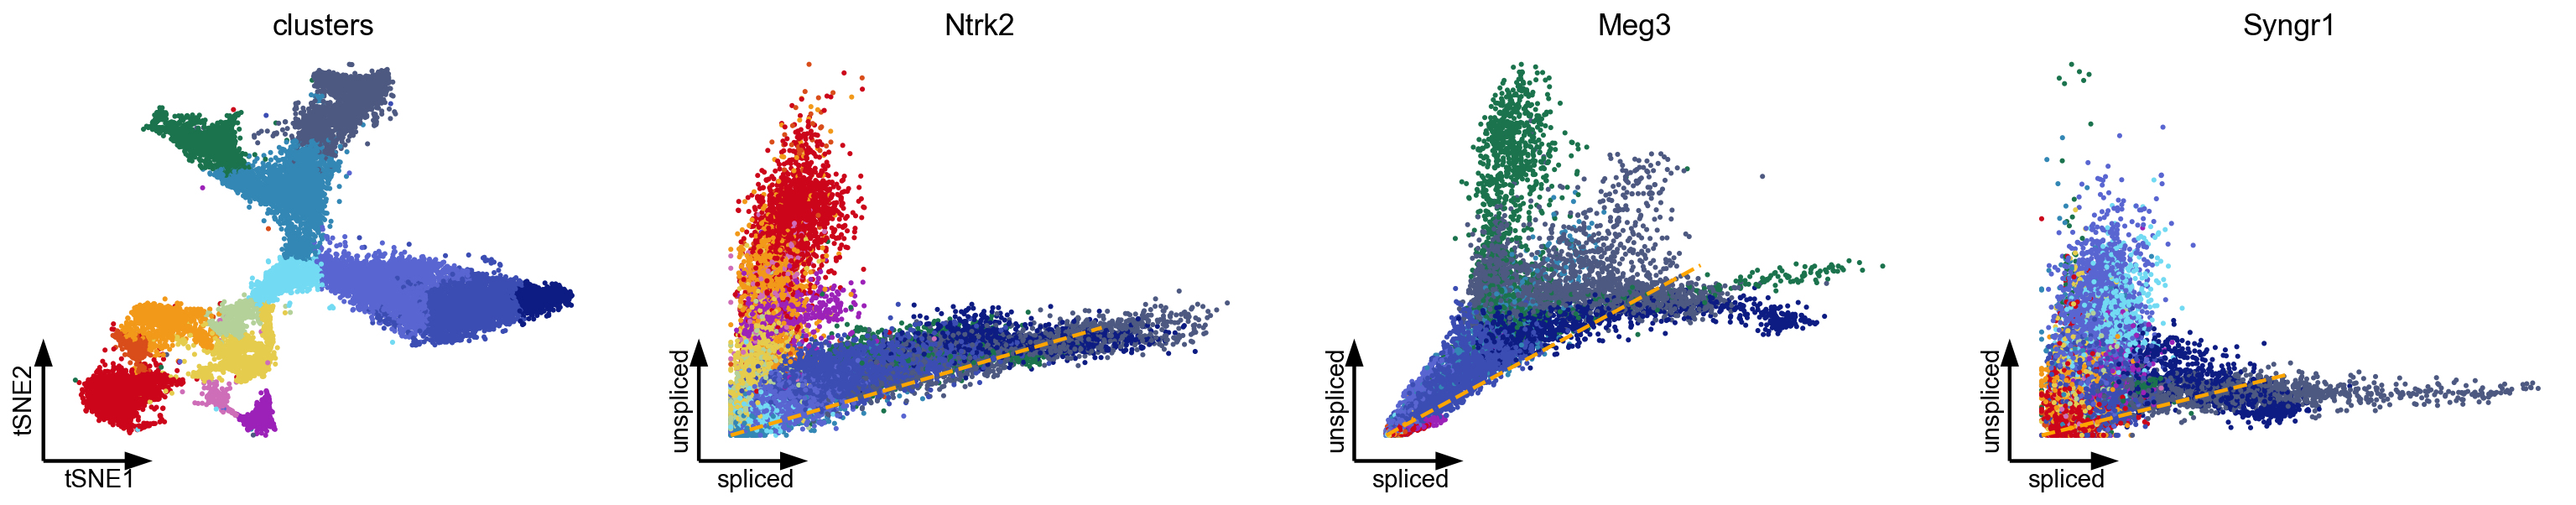

In [6]:
kwargs = dict(linecolor='orange', s=30, linewidth=2, frameon='artist', dpi=80)
scv.pl.scatter(adata, basis=['tsne'] + var_names, vkey='velocity', **kwargs)

#### Dentate Gyrus II
Reproducing Suppl. Fig. 11 from Bergen et al. ([Nature Biotech, 2020](https://doi.org/10.1038/s41587-020-0591-3)).

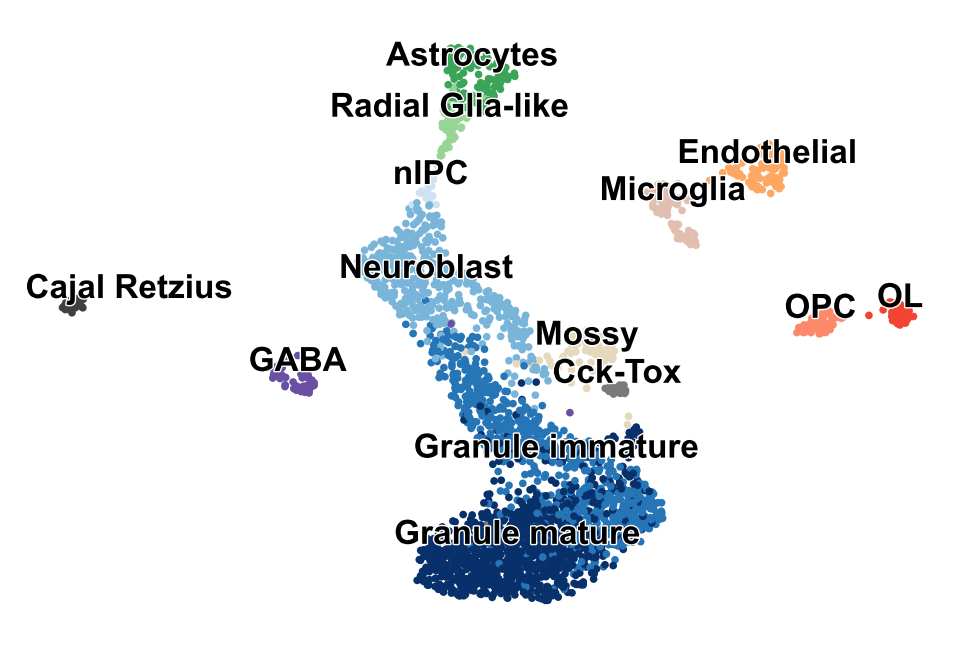

In [7]:
adata = scv.datasets.dentategyrus()
scv.pl.scatter(adata, legend_fontsize=12, legend_align_text=True, title='')

In [8]:
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_neighbors=30)

var_names = ['Tmsb10', 'Fam155a', 'Hn1']
scv.tl.differential_kinetic_test(adata, var_names=var_names, groupby='clusters')

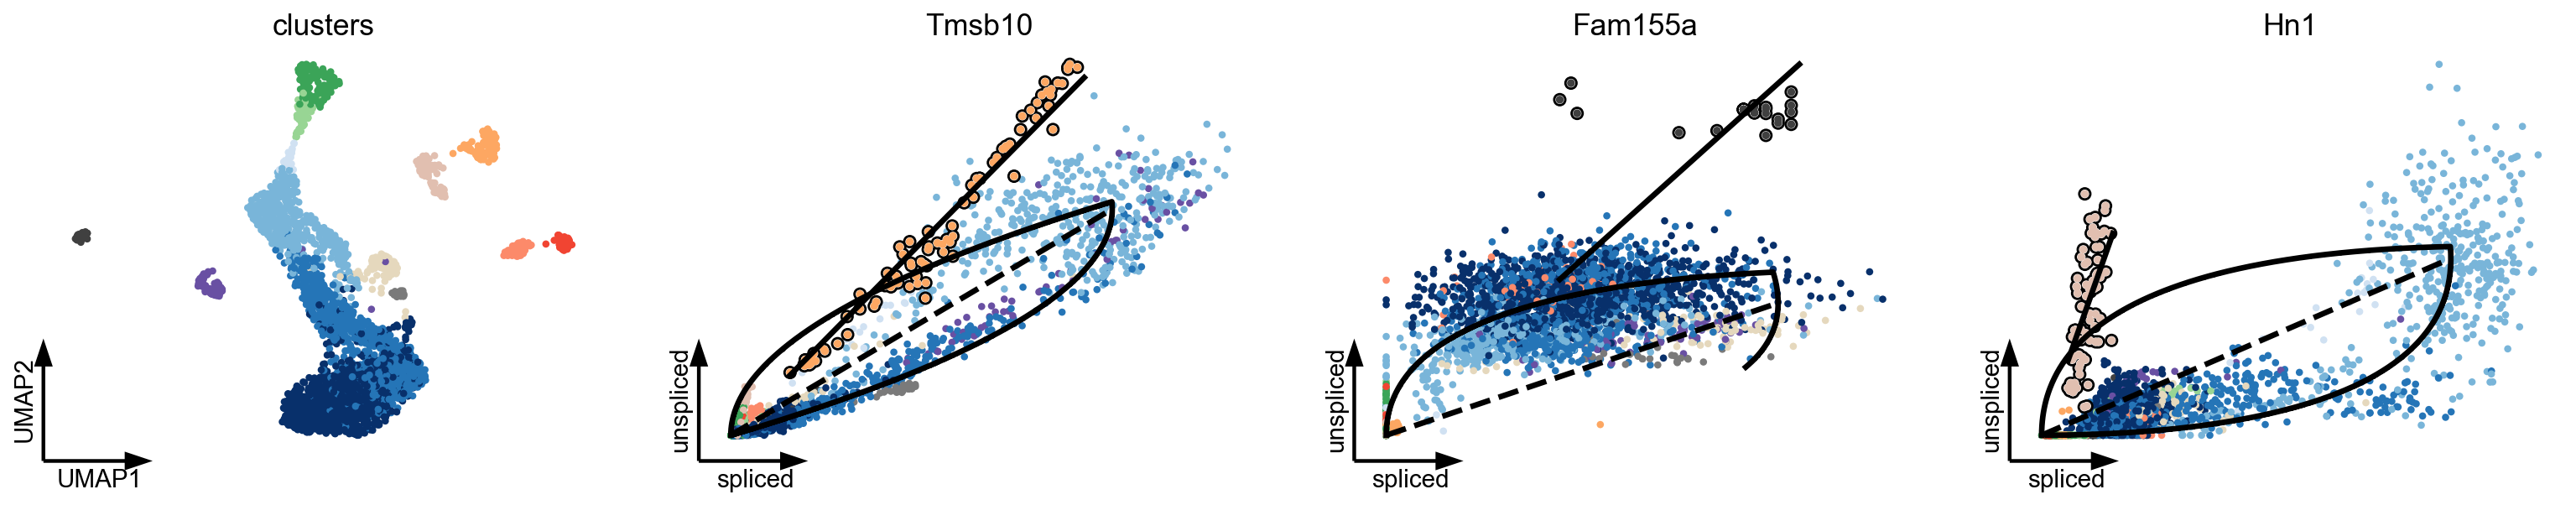

fit_diff_kinetics  fit_pval_kinetics
index                                       
Tmsb10        Endothelial           6.02e-16
Fam155a     Cajal Retzius          8.35e-161
Hn1             Microglia           3.02e-03

In [9]:
kwargs = dict(s=60, linewidth=3, add_linfit=True, frameon='artist')
scv.pl.scatter(adata, basis=['umap'] + var_names, add_outline='fit_diff_kinetics', dpi=80, **kwargs)

scv.get_df(adata[:, var_names], ['fit_diff_kinetics', 'fit_pval_kinetics'], precision=2)

***

## Transcriptional in erythroid lineage

As recently shown in mouse gastrulation (Barile et al, 2020), a boost in expression has been observed in erythroid maturation, possibly induced by a change in transcription rate (Fig. 2b). Interestingly, we made the same observation in human bone marrow CD34+ hematopoietic cells (Setty et al, 2019). This up-regulating boost in expression would incorrectly yield negative velocity estimates indicating down-regulation. 

**Proposed Solution**: State/time-variable rates, multivariate models (see manuscript). 

#### Mouse gastrulation
Reproducing Fig. 3 from Barile et al. ([BioRxiv, 2021](https://doi.org/10.1101/2020.12.21.423773)).

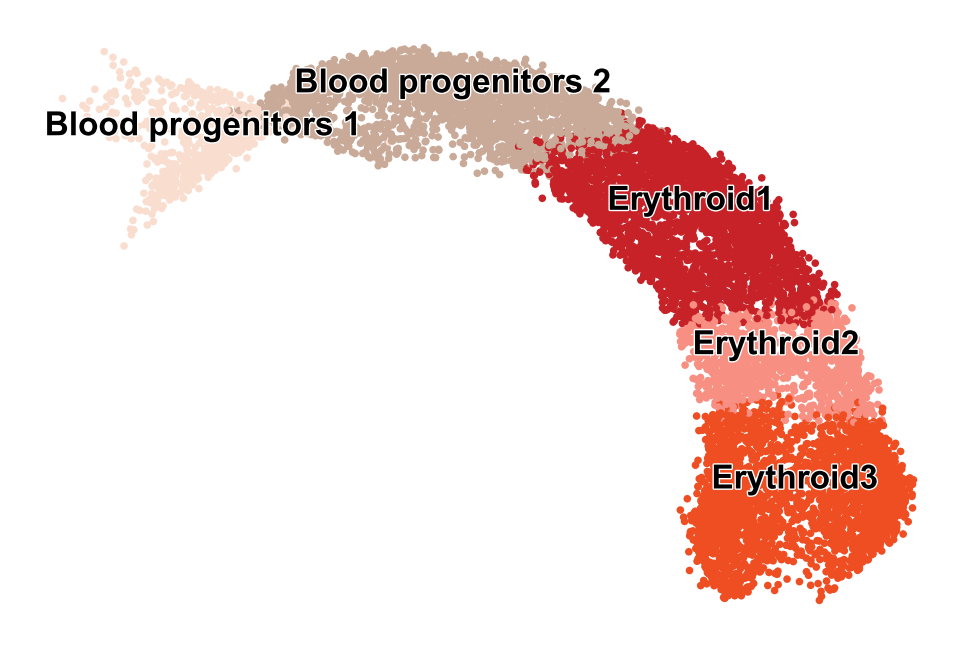

In [10]:
adata = scv.datasets.gastrulation_erythroid()
scv.pl.scatter(adata, c='celltype', s=30, legend_align_text=True, legend_fontsize=12, title='')

In [11]:
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata)
scv.tl.velocity(adata)

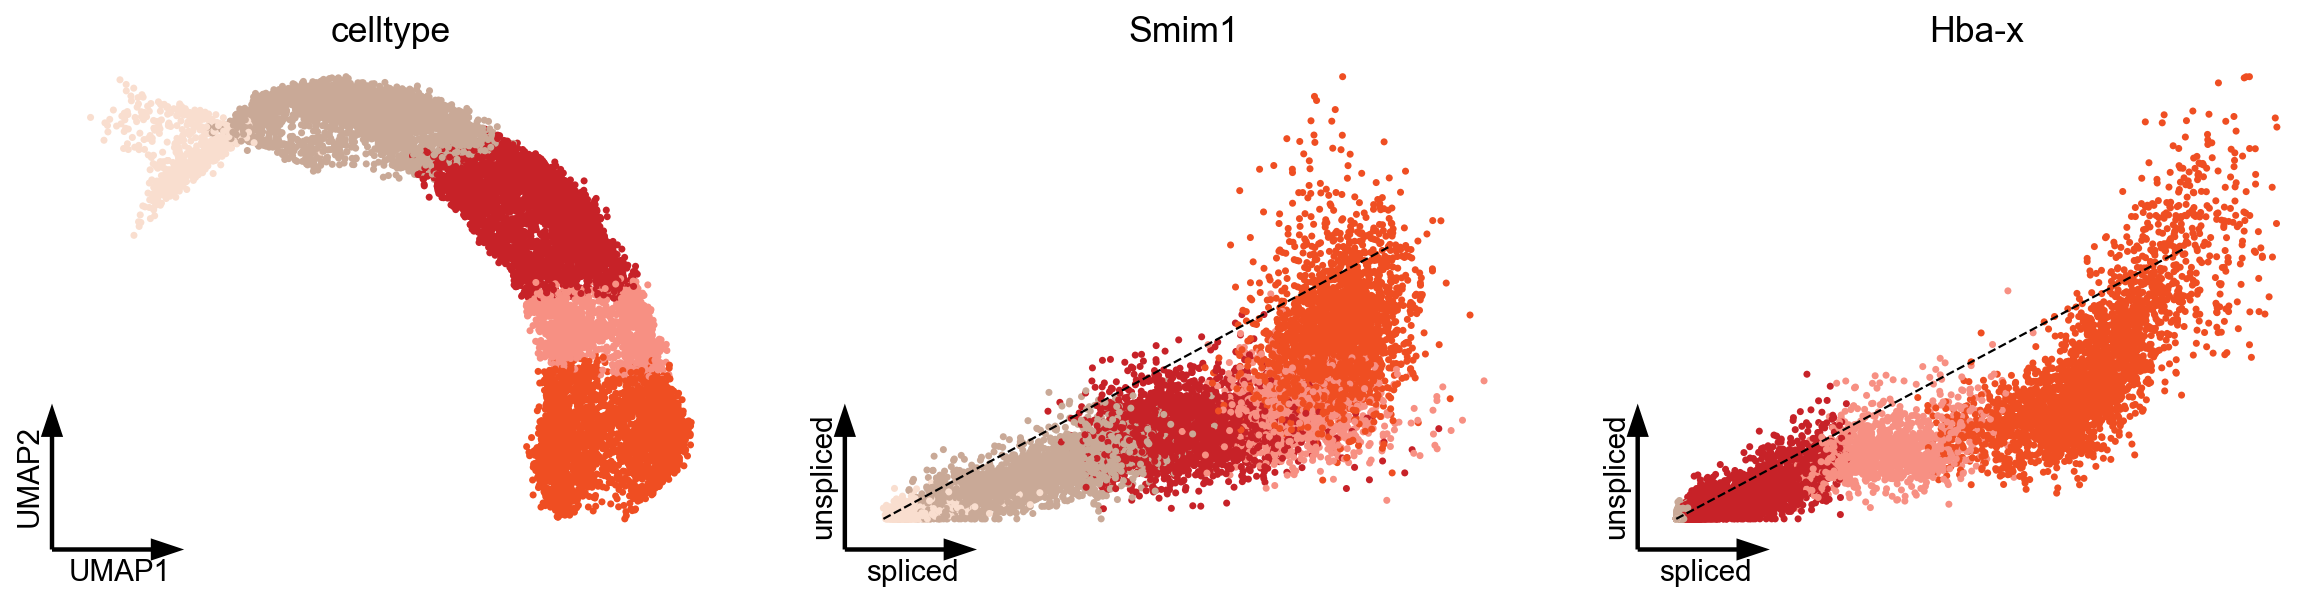

In [12]:
var_names = ['umap', 'Smim1', 'Hba-x']
scv.pl.scatter(adata, basis=var_names, c='celltype', vkey='velocity', frameon='artist', s=40, dpi=80)

&nbsp;
#### Human CD3datasets bone marrow
Data from Setty et al. ([Nature Biotech, 2019](https://doi.org/10.1038/s41587-019-0068-4)).

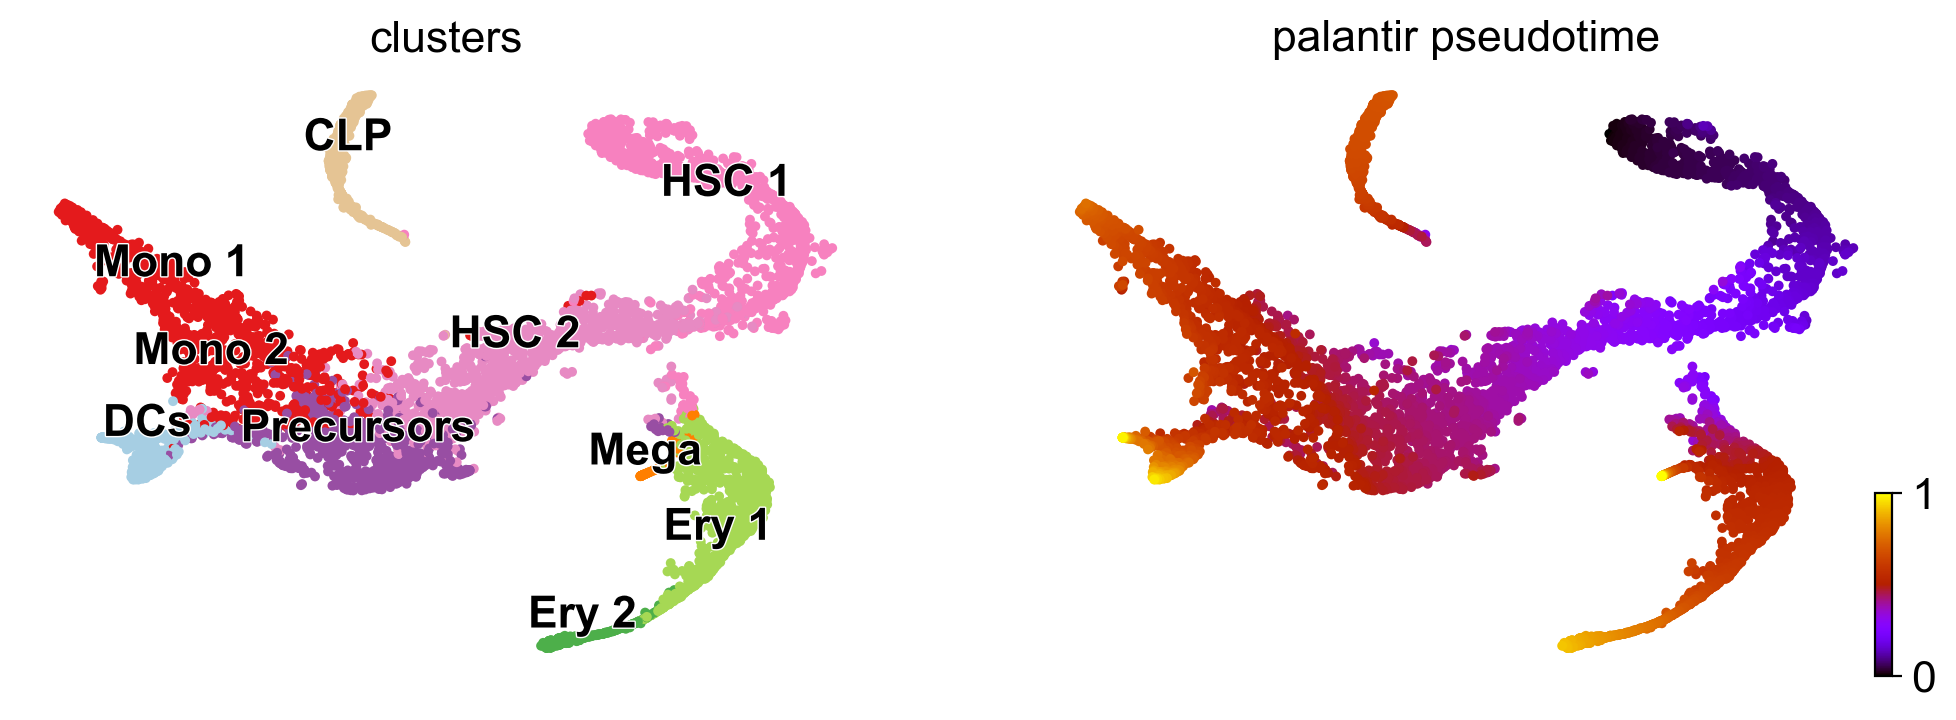

In [15]:
adata = scv.datasets.bonemarrow()
scv.pl.scatter(
    adata, c=['clusters', 'palantir_pseudotime'], cmap='gnuplot', legend_align_text=True, legend_loc='on data', s=50
)

In [16]:
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata)
scv.tl.velocity(adata)

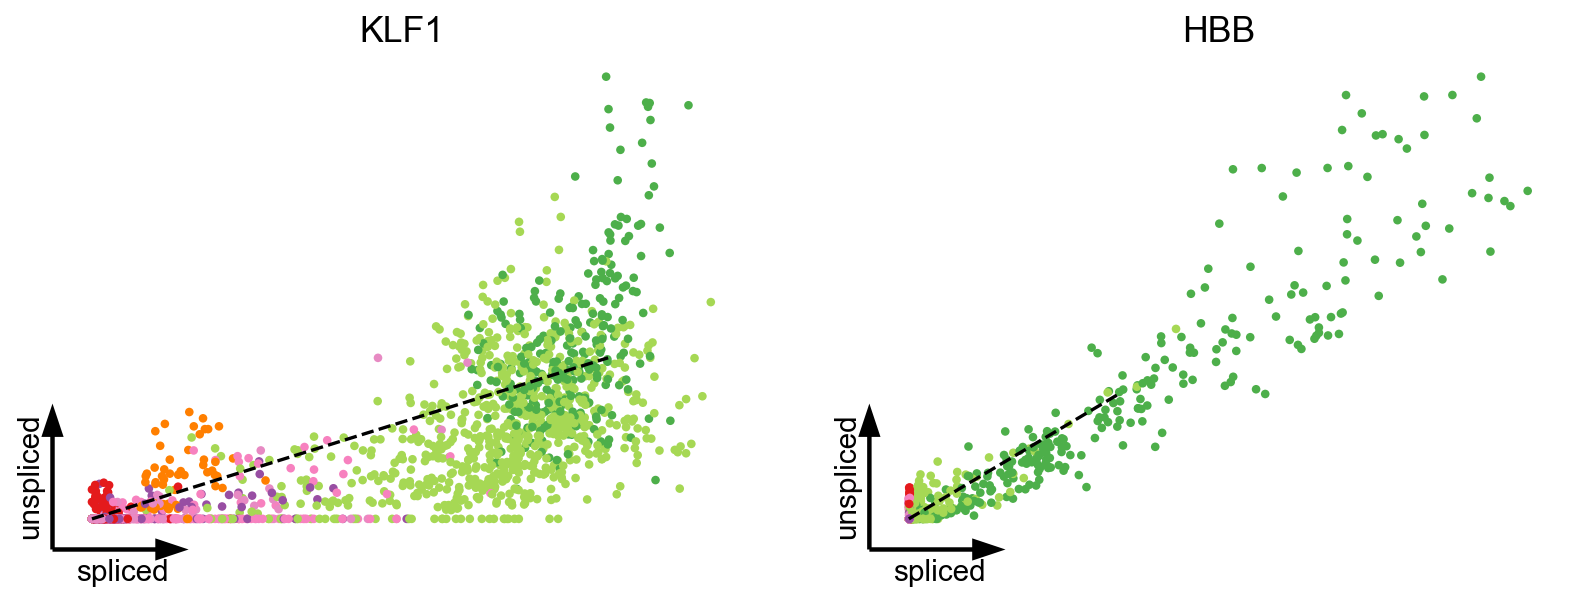

In [17]:
scv.pl.scatter(adata, basis=['KLF1', 'HBB'], vkey='velocity', s=60, linewidth=1.5, frameon='artist', dpi=80)

***

## Mature cell types in PBMCs
We examined erroneously inferred directions in mature cell types in PBMCs (Zheng et al, 2017), where we would not have expected any explicit cell type transition. To confirm that these directions indeed arise from distorted estimates and their projection, we show that the directions were also inferred even if using three top-likelihood selected genes only (*NKG7, IGHM, GNLY*) all of which show noisy phase portraits without any indication of cell type transitions. Hence, the unexpected projected directions are likely due to velocities being estimated independently of noise levels and uncertainty in estimates not being propagated into the projection. A simulation of mature cell types further supports the possibility of false projections as projected arrows are obtained that are not seen in the ground-truth vector field (Fig. 2c).

**Proposed Solution**: Stochastic models, multi-modal omics (see manuscript). 

#### PBMCs
Data from Zheng et al. ([Nature Comm., 2017](https://www.nature.com/articles/ncomms14049)).

In [18]:
adata = scv.datasets.pbmc68k()
scv.pp.remove_duplicate_cells(adata)
adata.obsm["X_tsne"][:, 0] *= -1

  0%|          | 0.00/118M [00:00<?, ?B/s]

In [19]:
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata)
scv.tl.velocity(adata)

In [20]:
scv.tl.recover_dynamics(adata, n_jobs=-1)

  0%|          | 0/39 [00:00<?, ?gene/s]

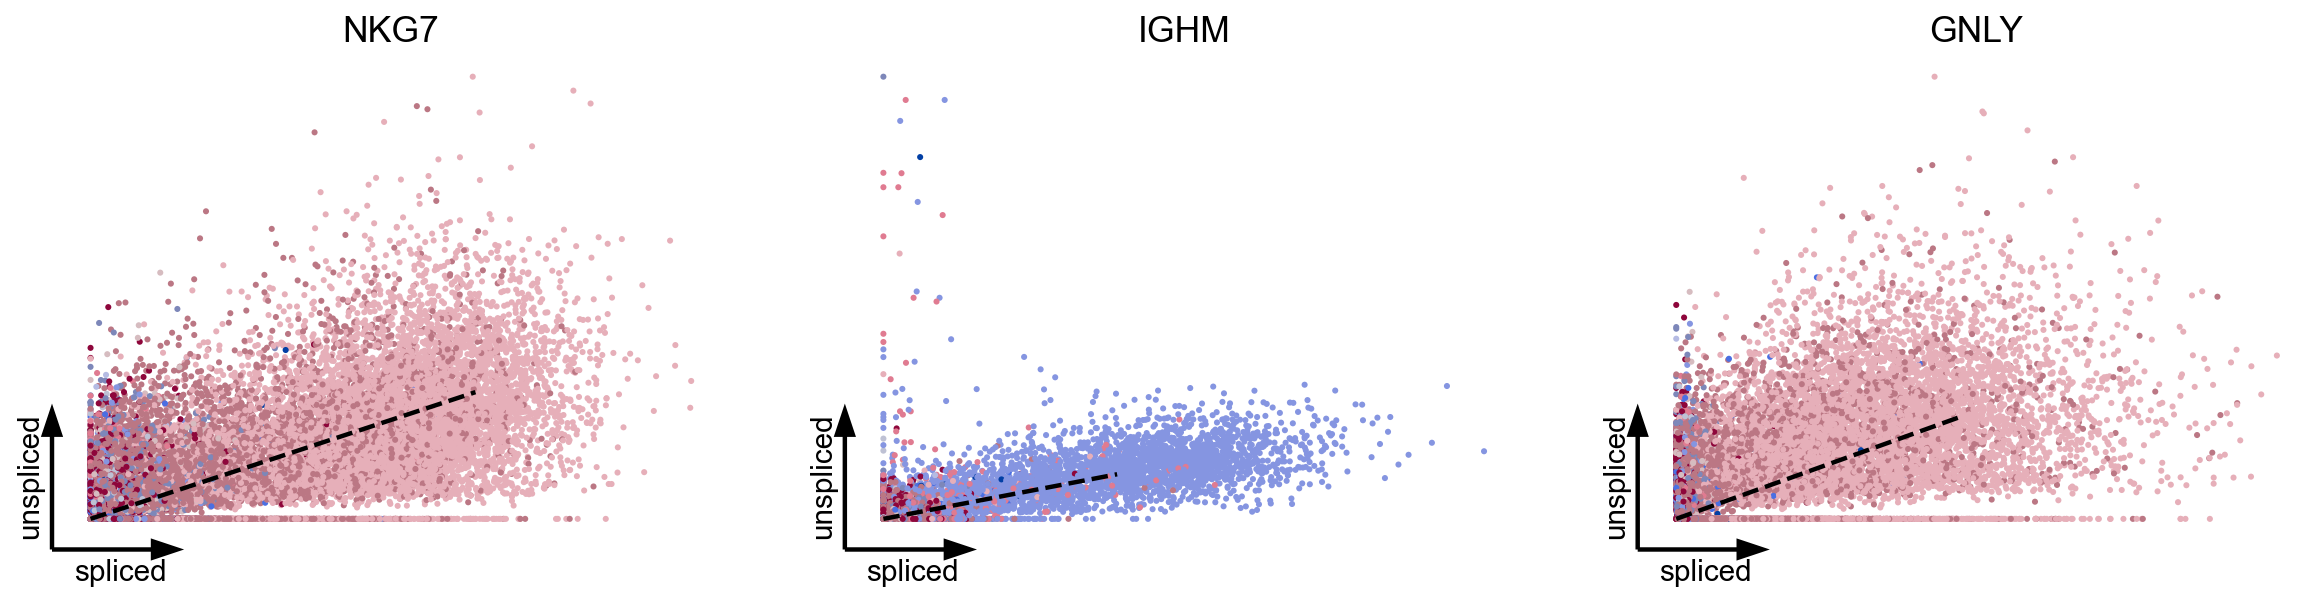

In [21]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index
scv.pl.scatter(adata, basis=top_genes[:3], vkey='velocity', c='celltype', ncols=5, s=30, linewidth=2, frameon='artist', dpi=80)

In [22]:
scv.tl.velocity_graph(adata, gene_subset=top_genes[:3], n_jobs=-1)
scv.tl.velocity_embedding(adata)

  0%|          | 0/65877 [00:00<?, ?cells/s]

In [23]:
adata.layers['velocity_with_noise'] = adata.layers['velocity'] + np.random.normal(adata.layers['velocity'], scale=adata.layers['Ms'].std(0))

scv.tl.velocity_graph(adata, gene_subset=top_genes[:3], vkey='velocity_with_noise', n_jobs=-1)
scv.tl.velocity_embedding(adata, vkey='velocity_with_noise', autoscale=False)

  0%|          | 0/65877 [00:00<?, ?cells/s]

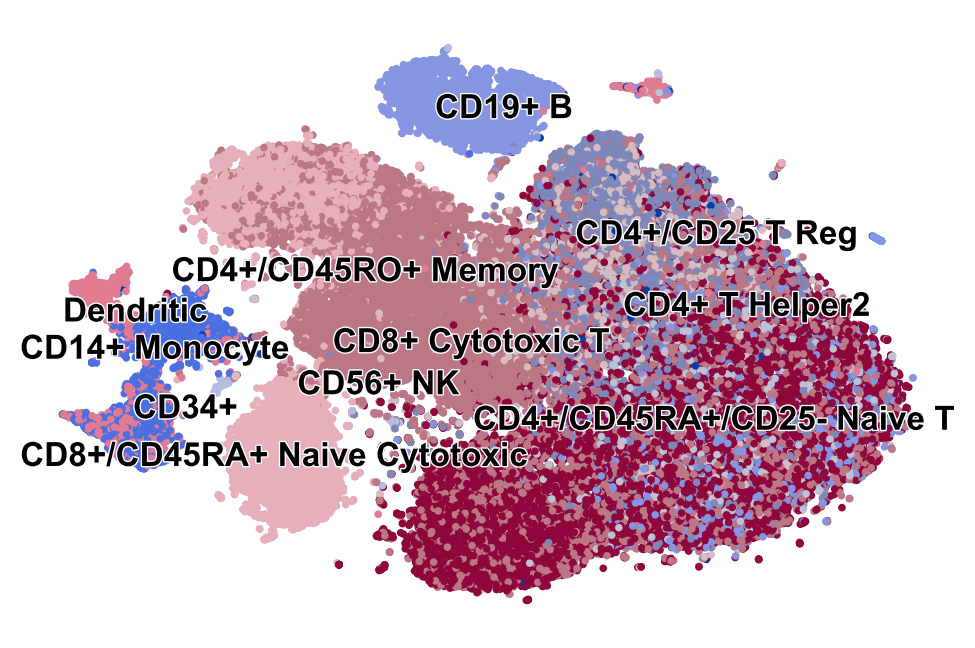

In [24]:
scv.pl.scatter(adata, c='celltype', s=30, legend_fontsize=12, legend_align_text=True, title='')

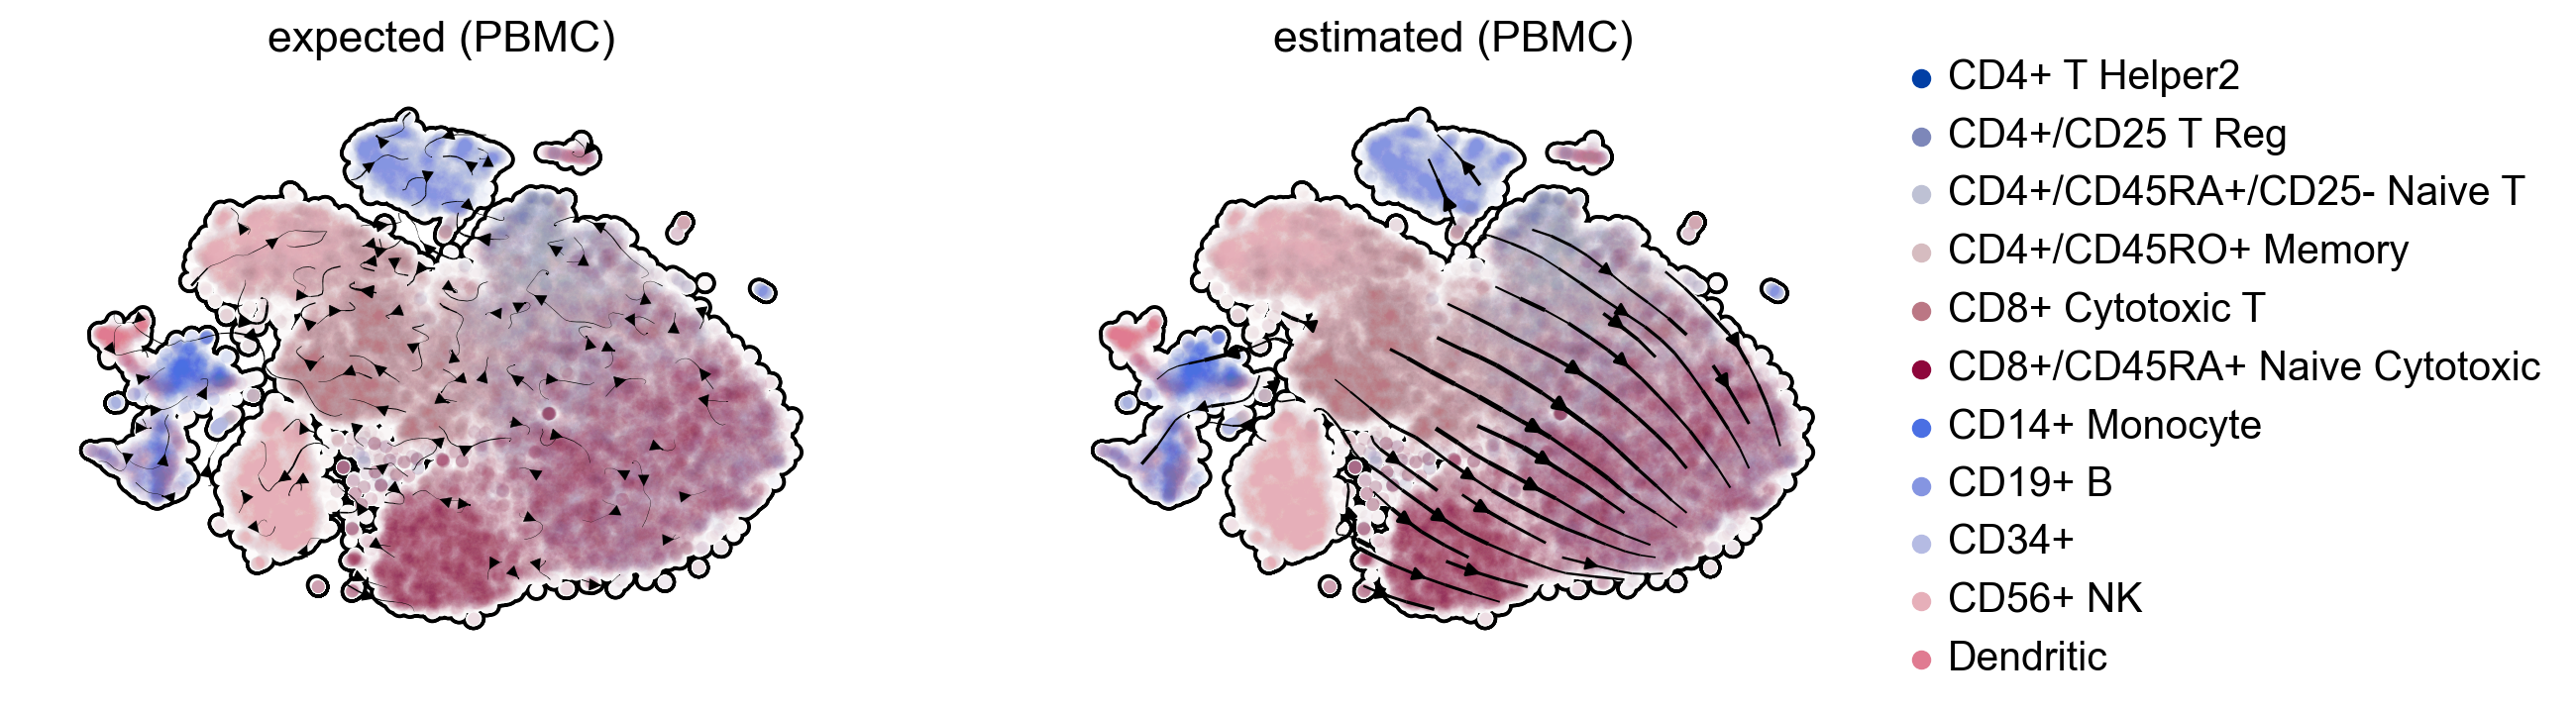

In [26]:
gs = scv.pl.gridspec(2)

kwargs = dict(color='celltype', density=.8, add_margin=.1, alpha=.02, min_mass=3.5, add_outline=True, frameon=False)
scv.pl.velocity_embedding_stream(adata, vkey='velocity_with_noise', legend_loc='none', title='expected (PBMC)', ax=gs[0], **kwargs)
scv.pl.velocity_embedding_stream(adata, linewidth=1.5, legend_loc='right', title='estimated (PBMC)', ax=gs[1], **kwargs)

#### Simulated data with mature states
to emulate results from PBMCs

The correlation threshold has been reduced to -5.4128.
Please be cautious when interpreting results.


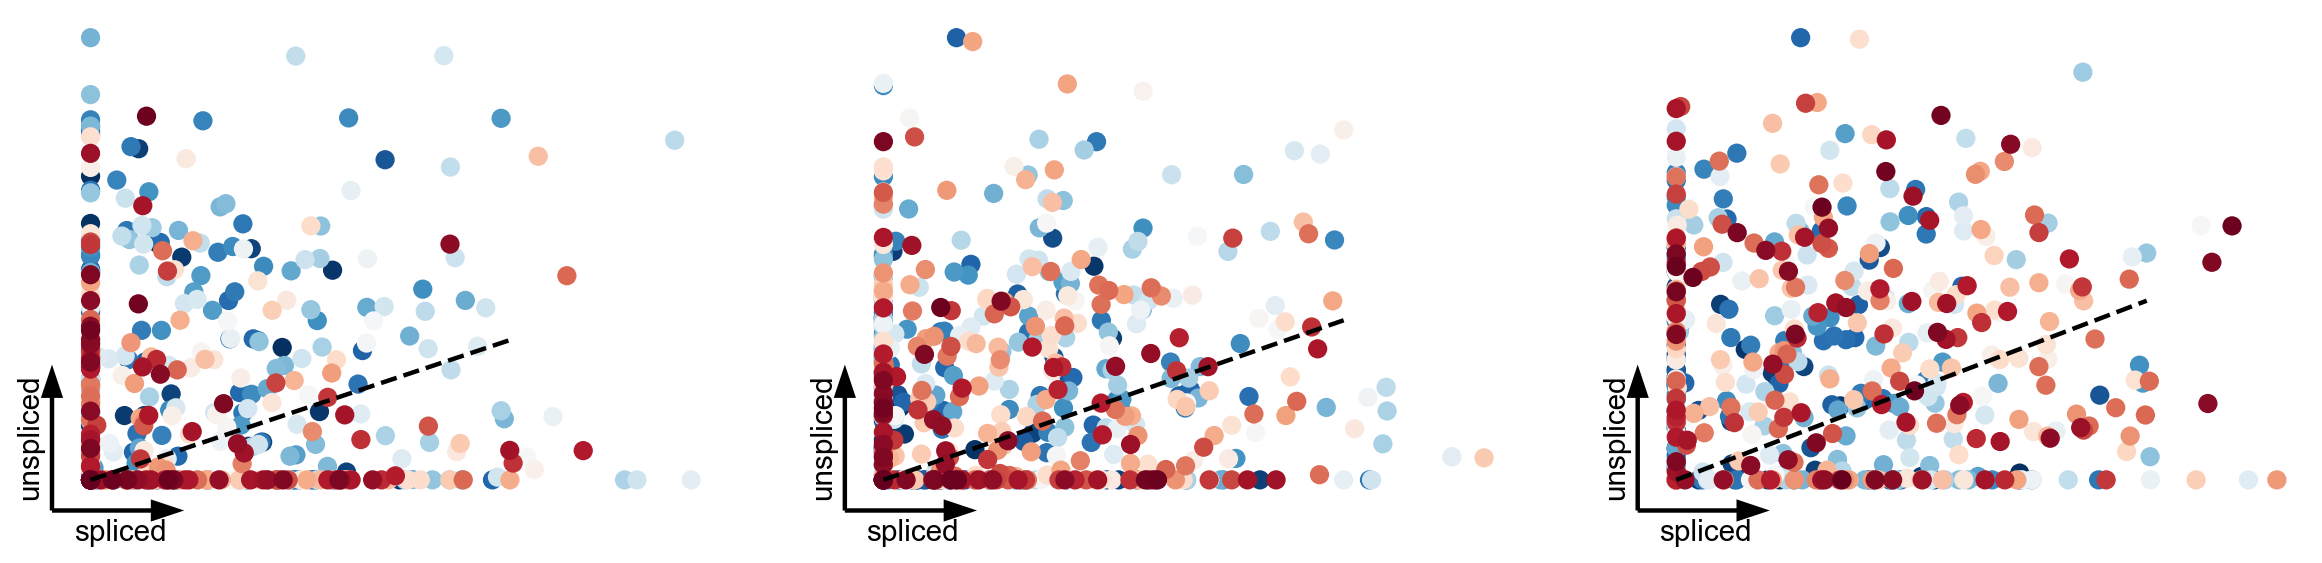

  0%|          | 0/500 [00:00<?, ?cells/s]

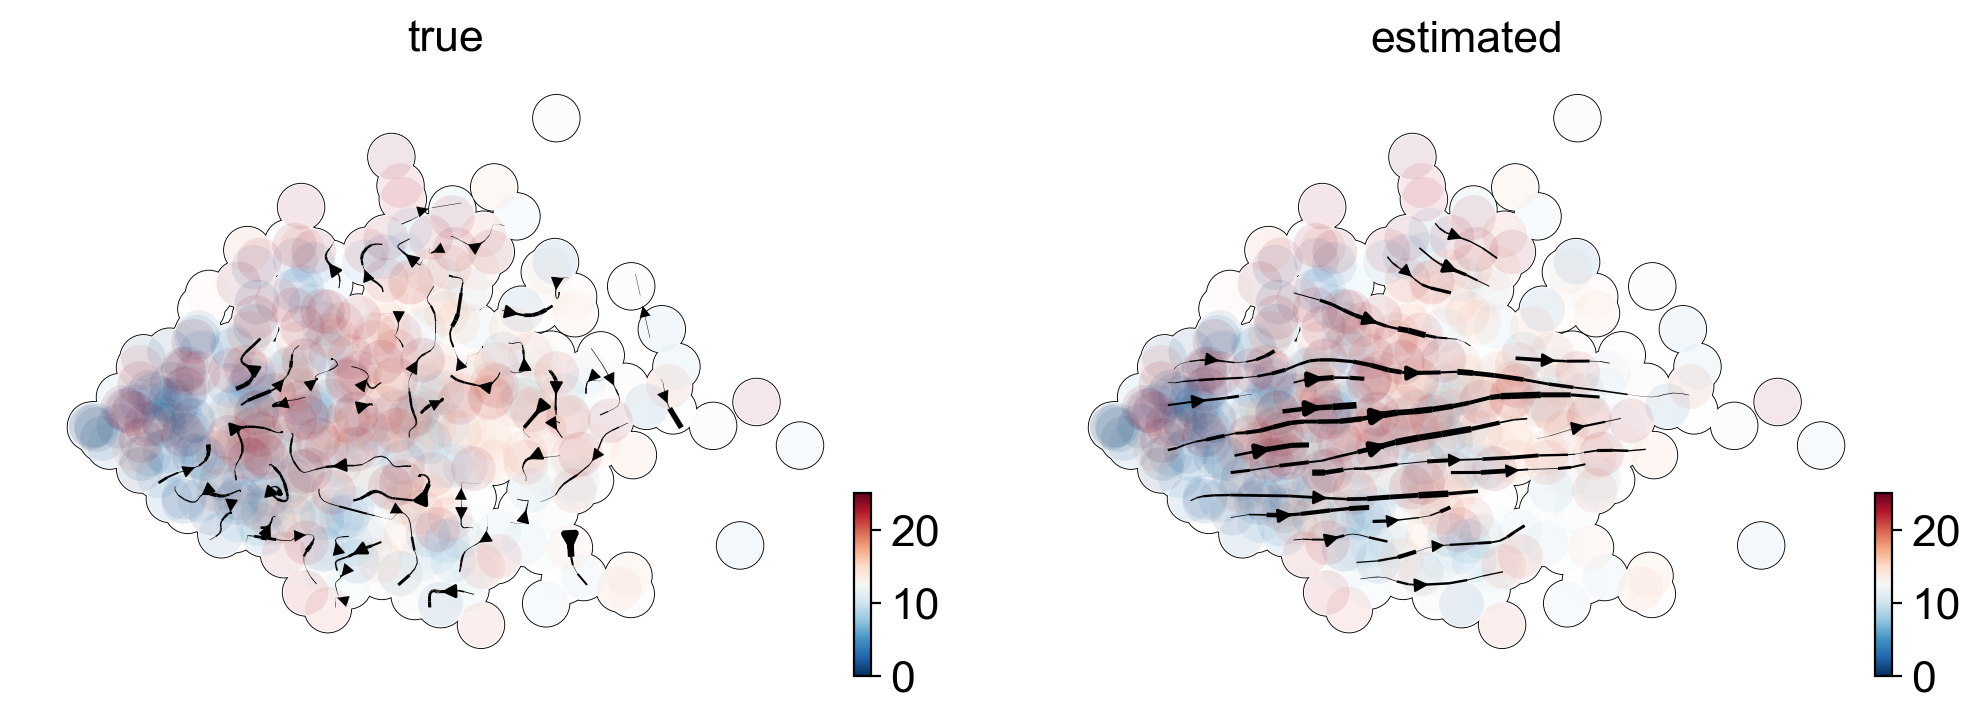

In [27]:
adata = scv.datasets.simulation(n_obs=500, n_vars=10, t_max=25, alpha=5, beta=.3, gamma=.5, noise_level=10)
scv.pp.pca(adata)
scv.tl.velocity(adata)
scv.pl.scatter(adata, basis=adata.var_names[:3], s=300, c='true_t', use_raw=True, frameon='artist', colorbar=False, title='', linewidth=2, dpi=80)

adata.var['velocity_genes'] = True
scv.tl.velocity_graph(adata)

gs = scv.pl.gridspec(2)

kwargs = dict(linewidth=1.5, density=.8, color='true_t', frameon=False, add_margin=.1, alpha=.1, min_mass=3.5, add_outline=True, outline_width=(.02, .02))
V = adata.var['true_beta'].values * adata.layers['unspliced'] - adata.var['true_gamma'].values * adata.layers['spliced'] 

scv.pl.velocity_embedding_stream(adata, V=V, basis='pca', title='true', ax=gs[0], **kwargs)
scv.pl.velocity_embedding_stream(adata, basis='pca', title='estimated', ax=gs[1], **kwargs)

***

## Direction reversal  in hematopoiesis due to time-dependent rates
Finally, we investigated potential issues in hematopoiesis, using cord blood CD34+ cells (unpublished data), where we obtain a direction reversal from what is biologically expected. Using simulated data, we show that reversed directions in the projected arrows can be explained by time-dependent degradation rates (Fig. 2d).

#### Simulated data with time-dependent rates

In [28]:
# simulate data with constant rate
adata = scv.datasets.simulation(n_obs=500, n_vars=10, t_max=25, alpha=5, beta=.3, gamma=.5, noise_level=.8)
scv.pp.pca(adata)
scv.tl.velocity(adata)

# simulate data with time-dep rate
n_obs = 500
alpha = [5] * 30
gamma = [.5] * 30

# three genes with time-dependent rates
tnew = np.linspace(.1, 5, num=n_obs)
gamma_t = 5 * (1 - np.exp(-.3*tnew))
for i in [0,1,5]:
    alpha[i] = 30
    gamma[i] = gamma_t

adata_t = scv.datasets.simulation(n_obs=n_obs, n_vars=30, t_max=25, alpha=alpha, beta=.3, gamma=gamma, noise_level=.8)

scv.pp.moments(adata_t)
scv.tl.velocity(adata_t)

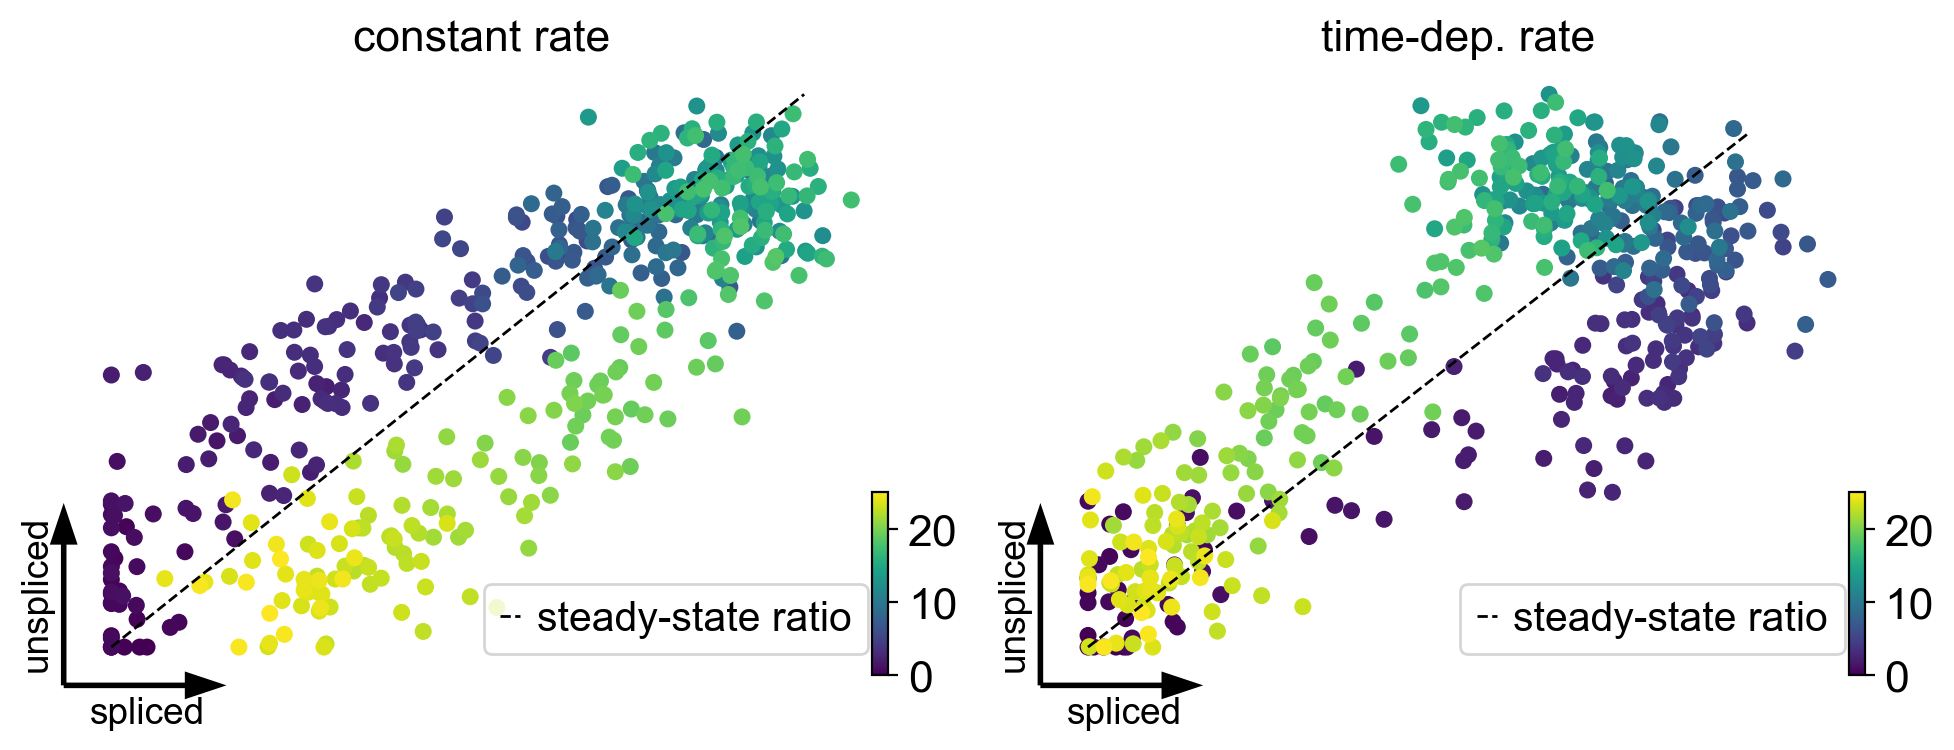

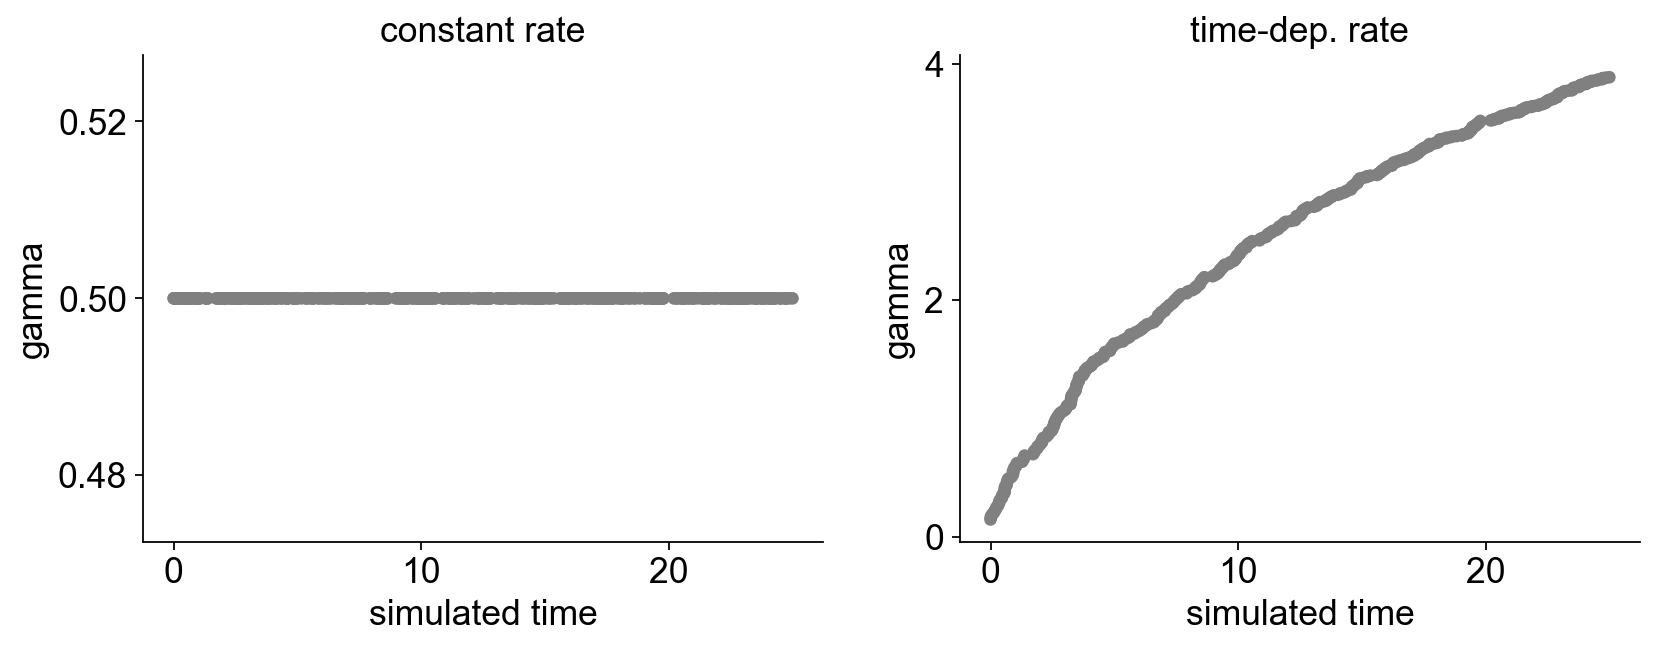

In [29]:
gs = scv.pl.gridspec()

kwargs = dict(c='true_t', cmap='viridis', s=150, use_raw=True, frameon='artist', dpi=80)
scv.pl.scatter(adata, basis=adata.var_names[5], ax=gs[0], title='constant rate', **kwargs)
scv.pl.scatter(adata_t, basis=adata.var_names[5], ax=gs[1], title='time-dep. rate', **kwargs)

adata_t.obs['gamma'] = .5
adata_t.obs['gamma_t'] = gamma_t
kwargs = dict(xlabel='simulated time', ylabel='gamma', title=['constant rate', 'time-dep. rate'])
scv.pl.scatter(adata_t, x='true_t', y=['gamma', 'gamma_t'], frameon='lb', dpi=80, **kwargs)

  0%|          | 0/500 [00:00<?, ?cells/s]

  0%|          | 0/500 [00:00<?, ?cells/s]

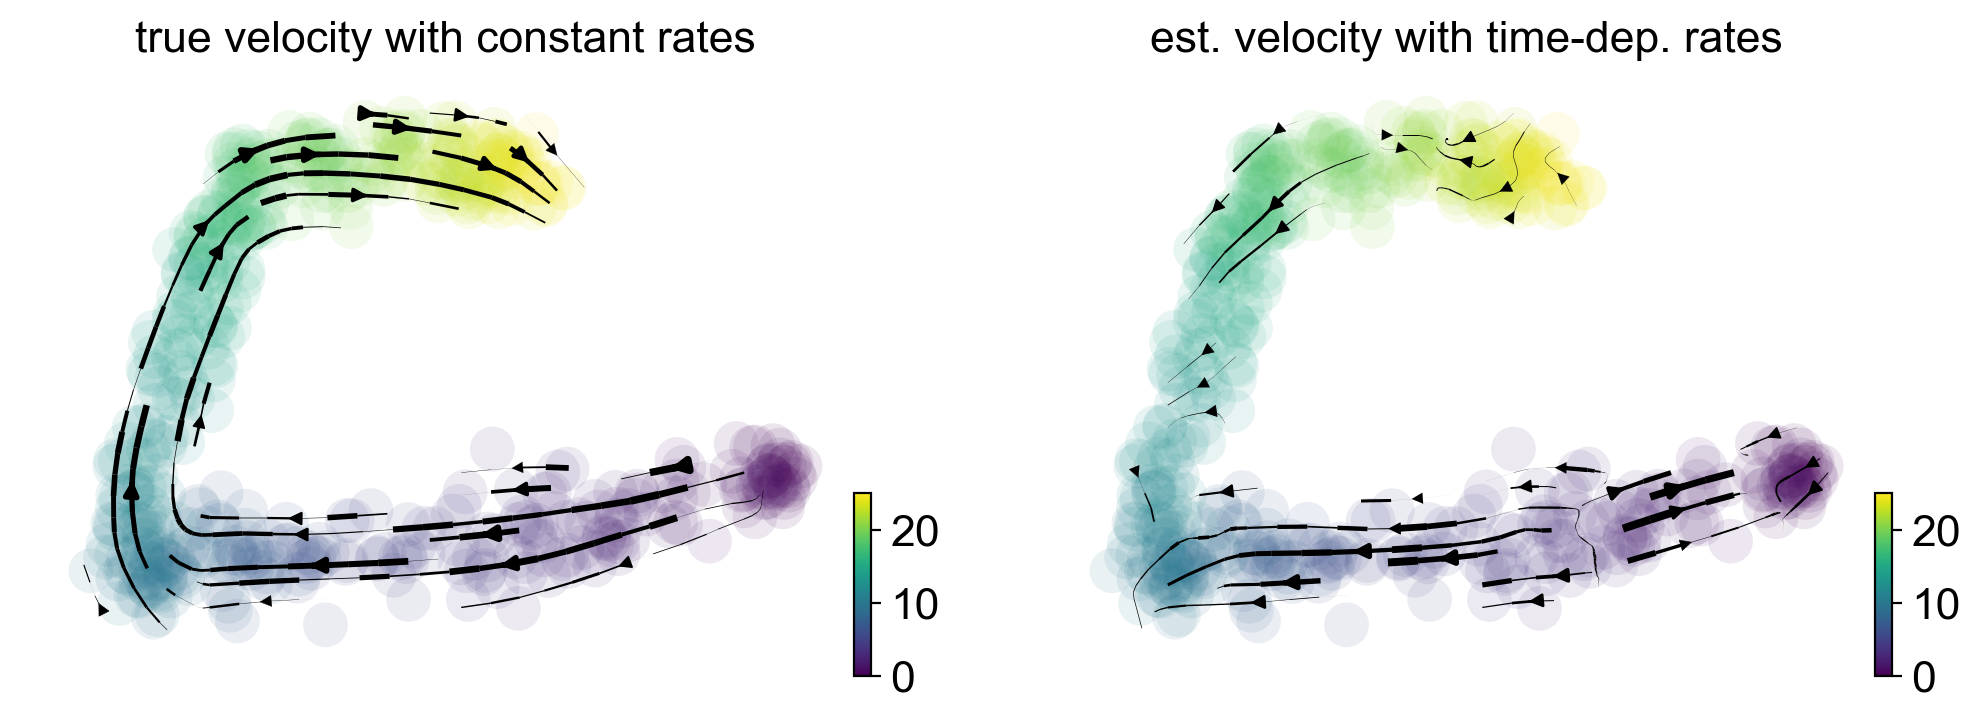

In [30]:
adata.var['velocity_genes'] = True
scv.tl.velocity_graph(adata)

adata_t.var['velocity_genes'] = True
scv.tl.velocity_graph(adata_t)

gs = scv.pl.gridspec(2)
adata_t.obsm['X_pca'] = adata.obsm['X_pca']
kwargs = dict(linewidth=1.5, density=.8, color='true_t', frameon=False, cmap='viridis', add_margin=.1, alpha=.1)
scv.pl.velocity_embedding_stream(adata, basis='pca', show=False, title='true velocity with constant rates', **kwargs, ax=gs[0])
scv.pl.velocity_embedding_stream(adata_t, basis='pca', title='est. velocity with time-dep. rates', **kwargs, ax=gs[1])